In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [272]:
def pick_random_spot(space_size):
    return (random.random() * space_size[0], random.random() * space_size[1])

def pick_random_spot_on_circle(radius):
    angle = random.random() * 2 * np.pi
    return (np.cos(angle) * radius, np.sin(angle) * radius)


def find_max_circle_from_spot(spot_coords, df_extant, df_inventory, space_size):
    radius = min(list(spot_coords) + [space - coord for coord, space in zip(spot_coords, space_size)])
    if df_extant.shape[0] == 0: return radius
    dist_min = df_extant.apply(
        lambda x: (
            ((spot_coords[0] - x['x']) ** 2 + (spot_coords[1] - x['y']) ** 2) ** 0.5
            - df_inventory.set_index('item').loc[x['item']]['diameter'] / 2
            ), axis=1
        ).min()
    return min([radius, dist_min])

def seed_item(df_extant, df_inventory, space_size):
    spot_coords = pick_random_spot(space_size)
    clearance_diameter = find_max_circle_from_spot(spot_coords, df_extant, df_inventory, space_size) * 2
    if clearance_diameter < df_inventory['diameter'].min():
        return (False, )
    item = df_inventory[df_inventory['diameter'] <= clearance_diameter].sample(1)
    return (
        True, pd.DataFrame({'item': item['item'], 'x': spot_coords[0], 'y': spot_coords[1]})
    )

def spread_item(df_extant, df_inventory, space_size):
    most_recent_item = df_inventory[df_inventory['item'] == df_extant.iloc[-1]['item']]
    spot_coords = pick_random_spot_on_circle(most_recent_item['diameter'].values[0])
    radius = find_max_circle_from_spot(spot_coords, df_extant, df_inventory, space_size)
    if radius <= most_recent_item['diameter'].values[0] / 2:
        return (False, )
    return (
        True, pd.DataFrame({'item': most_recent_item['item'], 'x': spot_coords[0], 'y': spot_coords[1]})
    )


def circle_area(diameter):
    return np.pi * (diameter / 2) ** 2

def space_remaining(df_extant, df_inventory, space_size):
    item_areas = [circle_area(df_inventory[df_inventory['item'] == i]['diameter'].values) for i in df_extant['item']]
    return space_size[0] * space_size[1] - sum(item_areas)

def seed_garden(df_inventory, space_size):
    df_extant = pd.DataFrame(
        {c: pd.Series(dtype=t) for c, t in {'item': 'str', 'x': 'float', 'y': 'float'}.items()}
        )
    min_item_area = circle_area(df_inventory['diameter'].min())
 
    count_unable_to_seed = 0
    i = 0
    while count_unable_to_seed < 100 and 5 * min_item_area < space_remaining(df_extant, df_inventory, space_size):
        new_item = seed_item(df_extant, df_inventory, space_size)
        if new_item[0] == False: 
            count_unable_to_seed += 1
            continue
        df_extant = pd.concat([df_extant, new_item[1]]) 

        prob_keep_seeding_same_item = 0.99
        count_unable_to_spread = 0
        while count_unable_to_spread < 10 and random.random() <= prob_keep_seeding_same_item:
            new_item = spread_item(df_extant, df_inventory, space_size)
            if new_item[0] == False:
                count_unable_to_spread += 1
                continue
            df_extant = pd.concat([df_extant, new_item[1]])
    
    return df_extant



In [222]:
def generate_circle(r, scale_pts=100):
    x = np.linspace(-r, r, int(scale_pts * r)).tolist()
    y = [np.sqrt(r ** 2 - xi ** 2) for xi in x]
    x += x[::-1]
    y += [-yi for yi in y[::-1]]
    return x, y

def plot_circle(x, y, r, ax):
    x_offset, y_offset = generate_circle(r)
    ax.plot([x + xi for xi in x_offset], [y + yi for yi in y_offset], 'k:', linewidth=1)
    ax.set(aspect='equal')

def plot_plants(df_extant, df_inventory, space_size):
    f, ax = plt.subplots()
    for i, row in df_extant.iterrows():
        plot_circle(
            row['x'], row['y'], df_inventory.loc[df_inventory['item'] == row['item'], 'diameter'].values[0] / 2, ax
            )

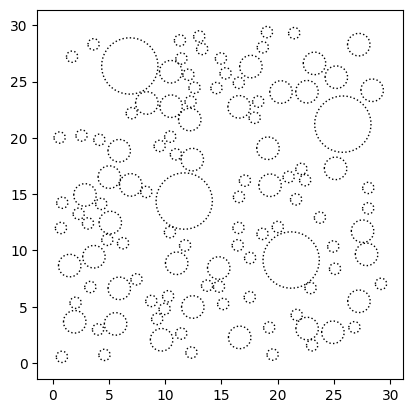

In [273]:
DF_PLANTS = pd.DataFrame({
    'item': ['A', 'B', 'C', 'D'],
    'diameter': [1., 5., 2., 10],
})
GARDEN_SIZE = (30, 30) # width, height

df_seeded = seed_garden(DF_PLANTS, GARDEN_SIZE)
plot_plants(df_seeded, DF_PLANTS, GARDEN_SIZE)